Please complete the `NotImplemented` parts of the code cells and write your answers in the markdown cells designated for your response to any questions asked. The tag `# AUTOGRADED` (all caps, with a space after `#`) should be at the beginning of each autograded code cell, so make sure that you do not change that. You are also not allowed to import any new package other than the ones already imported. Doing so will prevent the autograder from grading your code.

For the code submission, run the last cell in the notebook to create the submission zip file. If you are working in Colab, make sure to download and then upload a copy of the completed notebook itself to its working directory to be included in the zip file. Finally, submit the zip file to Gradescope.

After you finish the assignment and fill in your code and response where needed (all cells should have been run), save the notebook as a PDF using the `jupyter nbconvert --to pdf HW2.ipynb` command (via a notebook code cell or the command line directly) and submit the PDF to Gradescope under the PDF submission item. If you cannot get this to work locally, you can upload the notebook to Google Colab and create the PDF there. You can find the notebook containing the instruction for this on Canvas.

If you are running the notebook locally, make sure you have created a virtual environment (using `conda` for example) and have the proper packages installed. We are working with `python=3.10` and `torch>=2`.

Files to be included in submission:

- `HW2.ipynb`

- `model_config.yaml`

- `train_config.yaml`

- `state_dict.pth`

# Build and train a neural network for regression

The problem you are asked to solve is Airfoil Self-Noise prediction. Namely, given 5 features (Frequency in Hertz, Angle of attack in degrees, Chord length in meters, Free-stream velocity in meters per second, and Suction side displacement thickness in meters), your model is supposed to accurately predict the Scaled sound pressure level, in decibels. The datasets have been preprocessed for you and can be found as `train.npy` and `val.npy` in the `data` folder. You have to implement your custom dataset, model, and train function. We have also provided helper functions for you to keep track of model performance during training. Please make use of them, and try to understand their code as you may need to implement similar functions in the future.

In [346]:
# DO NOT MODIFY THIS CELL OR ADD ANY IMPORTS IN OTHER CELLS!

from typing import Union, Tuple, List, Sequence
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from HW2_utils import save_yaml, load_yaml, zip_files, Learning_Curve_Tracker

if torch.cuda.is_available():
    Device = 'cuda'
elif torch.backends.mps.is_available():
    Device = 'mps'
else:
    Device = 'cpu'

print(f'Device is {Device}')

Device is cpu


## Implement the dataset class (20)
First, you will implement a subclass of `torch.utils.data.Dataset` to define a custom dataset class. To do so, you will need to implement three methods for the subclass:

- `__init__` defines the dataset using the path to the data file (for example `data/train.npy` or `data/val.npy`). Your code should load the data using `np.load` and save it as attributes to be refereced in other methods that you implement. You can apply transformations like changing the dtype of data when saving them as attributes, which might be convenient.

- `__len__` should return a non-negative integer that is the total number of data points. This will be used by the dataloader to count and batch the data.

- `__getitem__` should return a single data sample (containing input, output pairs for this problem) using the index passed. Generally, the `__getitem__` method defines the behavior of an object when indexed using square brackets (like `a[i]`). 

Both datasets are of shape `(N, 6)` where N is the number of samples. The first five indexes of the last dimension contain the input features and the last one contains the output.

In [349]:
class AirFoilDataset(Dataset):

    def __init__(
            self,
            data_path: str,
            ):
        super().__init__()
        data = np.load(data_path)
        # process the data as torch tensors with the correct dtype and shape
        self.features = torch.tensor(data[:, :-1], dtype=torch.float32)
        self.labels = torch.tensor(data[:, -1:], dtype=torch.float32)    
        #NotImplemented

    def __len__(self):
        #NotImplemented
        return len(self.features)
    
    def __getitem__(
            self, 
            idx: int,
            ) -> Tuple[torch.FloatTensor, torch.FloatTensor]: # (5,), (1,)
        """
        Returns a tuple of (x, y) where x is the input data and y is the target label.
        shape of x: (5,)
        shape of y: (1,)
        """
        #NotImplemented
        return self.features[idx], self.labels[idx]

In [351]:
# testing the shapes and dtypes

data_path = './data/train.npy'
dataset = AirFoilDataset(data_path)

for idx in np.random.randint(0, len(dataset), 5):
    x, y = dataset[idx]
    assert x.dtype == torch.float32
    assert y.dtype == torch.float32
    assert x.shape == (5,)
    assert y.shape == (1,)

## Implement the model (30)

Implement your model class. Try to make use of modules like `nn.Sequential`, `nn.ModuleList`, and `nn.ModuleDict` to define a neural network with a modifiable number of layers. 

In [854]:
# # AUTOGRADED
# class Model(nn.Module):
#     def __init__(
#             self,
#             input_dim: int,
#             output_dim: int,
#             hidden_dims: list,
#             #NotImplemented
#         ):
#         super().__init__()
#         #NotImplemented
#         dims = [input_dim] + hidden_dims + [output_dim]
#         self.n_layers = len(dims) - 1
#         self.layers = nn.ModuleDict({
#             'linear_modules': nn.ModuleList([
#                 nn.Linear(dims[i], dims[i+1])
#                 for i in range(self.n_layers)
#             ]),

#             'activation_modules': nn.ModuleList([
#                 nn.ReLU() if i != len(dims)-2 else nn.Sigmoid()
#                 for i in range(self.n_layers)
#             ])
#         })
    
#     def forward(
#             self, 
#             x: torch.FloatTensor, # (batch_size, input_dim)
#             ) -> torch.FloatTensor: # (batch_size, output_dim)
#         # you can modify properties of the data before passing it through the model!
#         #NotImplemented
#         for i in range(self.n_layers):
#             x = self.layers['linear_modules'][i](x)
#             x = self.layers['activation_modules'][i](x)
#         return x
class Model(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, hidden_dims: list, activation: nn.Module = nn.ReLU):
        super(Model, self).__init__()

        dims = [input_dim] + hidden_dims + [output_dim]
        self.n_layers = len(dims) - 1

        # Store layers and activations inside a ModuleDict
        self.layers = nn.ModuleDict({
            'linear_modules': nn.ModuleList([
                nn.Linear(dims[i], dims[i + 1]) for i in range(self.n_layers)
            ]),
            'activation': activation()
        })

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        for i in range(self.n_layers - 1): 
            x = self.layers['linear_modules'][i](x)
            x = self.layers['activation'](x)

        x = self.layers['linear_modules'][-1](x)
        return x

In [845]:
# # AUTOGRADED
# class Model(nn.Module):
#     def __init__(self, input_dim: int, output_dim: int, hidden_dims: list, activation: nn.Module = nn.ReLU):
#         super(Model, self).__init__()

#         dims = [input_dim] + hidden_dims + [output_dim]
#         self.n_layers = len(dims) - 1

#         # Store layers and activations inside a ModuleDict
#         self.layers = nn.ModuleDict({
#             'linear_modules': nn.ModuleList([
#                 nn.Linear(dims[i], dims[i + 1]) for i in range(self.n_layers)
#             ]),
#             'activation': activation()
#         })

#     def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
#         for i in range(self.n_layers - 1): 
#             x = self.layers['linear_modules'][i](x)
#             x = self.layers['activation'](x)

#         x = self.layers['linear_modules'][-1](x)
#         return x

## Helper functions for tracking model performance

Before moving on to training, we provide an evaluation function for you to use during training. At the end of each epoch, use this function to calculate the loss on your training and validation dataset. Also, we provide a class to keep track of your losses with an option to plot the learning curve in real-time during training in the util file.

In [357]:
# DO NOT MODIFY THIS CELL!

# The first line is called a function decorator. It's a shorthand way to wrap a function with another function.

# Remember that torch always keeps track of the computations so we can calculate the gradients if we want to
# This can induce unnecessary overhead when we are not training!
# By using this function decorator, we are telling torch that we are not interested in keeping track of gradients.
# This can make the code run faster.

@torch.inference_mode() # this is a function decorator
def evaluate(
    model: nn.Module,
    dataloader: DataLoader,
    loss_fn = nn.MSELoss(reduction='sum'),
    device = Device,
    ):
    
    # Set the model to evaluation mode and move to the correct device
    # (because some layers like dropout or batchnorm have different behavior when training and evaluating)
    model.eval().to(device)

    total_loss = 0.
    n_samples = len(dataloader.dataset)
    for x, y in dataloader:

        # move data to the correct device and calculate the predictions
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        # calculate the loss
        total_loss += loss_fn(y_pred, y).item() # use .item() to extract the loss as a normal python scalar

    average_loss = total_loss / n_samples
    return average_loss

## Helper functions for evaluation and tracking model performance

Before moving on to training, we provide an evaluation function for you to use during training. At the end of each epoch, use this function to calculate the loss on your training and validation dataset. Also, we provide a class to keep track of your losses with an option to plot the learning curve in real-time during training in the util file.

In [856]:
# For train function, we use this decorator to make sure that torch keeps track of the gradients.
# Although this is the default behavior, it's good practice to make it explicit.
@torch.enable_grad()
def train(
    model: nn.Module,
    train_data: Dataset,
    val_data: Dataset,

    # training hyperparameters:
    n_epochs: int,
    batch_size: int,
    opt_name: str, # Name of the optimizer class in torch.optim
    opt_config: dict = {}, # default setting. You can pass more options to the optimizer
    lr_scheduler_name: Union[str, None] = None, # Name of the learning rate scheduler class in torch.optim.lr_scheduler. If None, no scheduler is used
    lr_scheduler_config: dict = {}, # default setting. You can pass more options to the scheduler
    
    device = Device,
    plot_freq = None,
    ):

    loss_fn = nn.MSELoss(reduction='mean')

    # initialize a learning curve tracker
    lct = Learning_Curve_Tracker(n_epochs, plot_freq)

    # create dataloaders
    #NotImplemented
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    # define your optimizer and learning rate scheduler.
    # use the getattr fuction or the .__getattribute__ method to get the optimizer class from torch.optim
    # For example, getattr(optim, 'Adam') or optim.__getattribute__('Adam') gives you optim.Adam
    # pass their config dictionaries using ** to unpack it as keyword arguments
    #NotImplemented
    optimizer_class = getattr(torch.optim, opt_name)
    optimizer = optimizer_class(model.parameters(), **opt_config)

    scheduler = None
    if lr_scheduler_name is not None:
        scheduler_class = getattr(torch.optim.lr_scheduler, lr_scheduler_name)
        scheduler = scheduler_class(optimizer, **lr_scheduler_config)

    model.to(device)

    epoch_pbar = tqdm(range(1, n_epochs+1), desc='Epochs', unit='epoch', leave=False, ncols=100)

    for epoch in epoch_pbar:

        # Each epoch will be fast. No need for a progres bar inside the epoch for train or test batches!
        # loop over training batches using the dataloader to traing the model
        #NotImplemented
        model.train()

        total_train_loss = 0.0
        
        
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            predictions = model(x_batch)
            loss = loss_fn(predictions, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() #* x_batch.size(0)
        
        # After the epoch is done, evaluate the model on the training and validation set
        #NotImplemented
        #avg_train_loss = total_train_loss / len(train_loader)
        # avg_train_loss = evaluate(model, train_loader)#, loss_fn, device)
        # avg_val_loss = evaluate(model, val_loader)#, loss_fn, device)
        avg_train_loss = evaluate(model, train_loader, nn.MSELoss(reduction='sum'), device)
        avg_val_loss = evaluate(model, val_loader,nn.MSELoss(reduction='sum'), device)

        # update the learning curve tracker and the learning rate scheduler
        #NotImplemented
        lct.update(avg_train_loss, avg_val_loss)

        if scheduler is not None:
            scheduler.step()

        epoch_pbar.set_postfix({"Train Loss": f"{avg_train_loss:.4f}", "Val Loss": f"{avg_val_loss:.4f}"})

    return lct.get_losses()
    

## train your model (10)

You have find a good set of hyperparameters for your model and your trianing. You will submit the successful config and state_dict. 10 points of your score depends on your model's performance on the test dataset, which will be evaluated by the autograder. Please run the final cell to save the model config and state to include them in your submission to Gradescope. Your score based on test loss will be:

- `loss <= 0.035`: 15 points (5 extra points)

- `0.035 < loss <= 0.05`: 10 points

- `0.05 < loss <= 0.07`: 5 points

- `loss > 0.07`: 0 points

Hyperparameters you can explore:

- model configuration: Try changing the model size like number of layers or hidden dimensions.

- optimizer: Look into the [online documentation](https://pytorch.org/docs/stable/optim.html) for different choices for the optimizer, as well as their hyperparameters and regularization options.

- learning rate scheduler: Look into the [online documentation](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) for different choices of schedulers for the learning rate of the optimizer and its hyperparameters, and how to use it.

- training hyperparameters: You can also try increasing the number of epochs or the batch size. Training the model for more epochs may resolve underfitting. Bigger batch size may also help with training stability.

In [516]:
# Load the data
if __name__ == '__main__':
    train_data = AirFoilDataset('data/train.npy')
    val_data = AirFoilDataset('data/val.npy')

In [518]:
# model_config = dict(
#     input_dim = 5,
#     output_dim = 1,
#     hidden_dims = [32, 64, 64, 32],
# )

# train_config = dict(
#     n_epochs = 100,
#     batch_size = 32,
#     opt_name = "Adam",
#     opt_config = {"lr": 0.001, "weight_decay": 1e-5},
#     lr_scheduler_name = "StepLR",
#     lr_scheduler_config = {"step_size": 20, "gamma": 0.5},
#     device = Device,
# ) # train 0.66

In [520]:
# Model and training configuration
# You can iterate using this cell to find the best configuration


# model_config = dict(
#     input_dim = 5,
#     output_dim = 1,
#     hidden_dims = [64, 128, 64],
# )

# train_config = dict(
#     n_epochs = 60,
#     batch_size = 64,
#     opt_name = "Adam",
#     opt_config = {"lr": 0.001, "weight_decay": 1e-5},
#     lr_scheduler_name = "StepLR",
#     lr_scheduler_config = {"step_size": 20, "gamma": 0.5},
#     device = Device,
# ) #train 0.6471

# model_config = dict(
#     input_dim = 5,
#     output_dim = 1,
#     hidden_dims = [32, 64], 
# )

# train_config = dict(
#     n_epochs = 100,  
#     batch_size = 64,
#     opt_name = "Adam",
#     opt_config = {"lr": 0.0005, "weight_decay": 1e-4},
#     lr_scheduler_name = "StepLR",
#     lr_scheduler_config = {"step_size": 10, "gamma": 0.8}, 
#     device = Device,
# ) #train loss = .77


# model_config = dict(
#     input_dim = 5,
#     output_dim = 1,
#     hidden_dims = [32, 64, 128, 256, 128, 64, 32], 
# )

# train_config = dict(
#     n_epochs = 100,  
#     batch_size = 64,
#     opt_name = "Adam",
#     opt_config = {"lr": 0.0005, "weight_decay": 1e-4},
#     lr_scheduler_name = "StepLR",
#     lr_scheduler_config = {"step_size": 10, "gamma": 0.8}, 
#     device = Device,
# ) # train 0.63

# model_config = dict(
#     input_dim = 5,
#     output_dim = 1,
#     hidden_dims = [128, 256, 256, 256, 128],
# )

# train_config = dict(
#     n_epochs = 60,
#     batch_size = 32,
#     opt_name = "Adam",
#     opt_config = {"lr": 0.001, "weight_decay": 1e-5},
#     lr_scheduler_name = "StepLR",
#     lr_scheduler_config = {"step_size": 20, "gamma": 0.5},
#     device = Device,
# ) #train loss = 0.61





In [522]:
# model_config = dict(
#     input_dim = 5,
#     output_dim = 1,
#     hidden_dims = [128, 256, 128, 64],  # Reduced width for efficiency
# )

# train_config = dict(
#     n_epochs = 60,
#     batch_size = 32,
#     opt_name = "Adam",
#     opt_config = {"lr": 0.001, "weight_decay": 1e-4},  # Increased weight decay
#     lr_scheduler_name = "StepLR",
#     lr_scheduler_config = {"step_size": 20, "gamma": 0.5},
#     device = Device,
# )


In [654]:
# model_config = dict(
#     input_dim = 5,
#     output_dim = 1,
#     hidden_dims = [512, 64, 64, 16],
# )

# train_config = dict(
#     n_epochs = 200,
#     batch_size = 128,
#     opt_name = "Adam",
#     opt_config = {"lr": 1e-3},#, "weight_decay": 1e-5},
#     lr_scheduler_name = None,# "StepLR",
#     lr_scheduler_config = (), #{"step_size": 30, "gamma": 0.5},
#     device = Device,
# ) #Val loss = 0.0711

In [743]:
# model_config = dict(
#     input_dim = 5,
#     output_dim = 1,
#     #hidden_dims = [512, 128, 64, 64, 16],
#     #hidden_dims = [1024, 512, 128, 64],
#     hidden_dims = [128, 512, 1024, 512, 128, 64],
#     #hidden_dims = [512, 128, 64, 64, 16],
# )

# train_config = dict(
#     n_epochs = 300,
#     batch_size = 32,
#     opt_name = "Adam",
#     opt_config = {"lr": 1e-3},#, "weight_decay": 1e-5},
#     lr_scheduler_name = "StepLR",
#     lr_scheduler_config = {"step_size": 50, "gamma": 0.7},
#     device = Device,
# ) #val loss = 0.051

In [811]:
# model_config = dict(
#     input_dim = 5,
#     output_dim = 1,
#     #hidden_dims = [512, 128, 64, 64, 16],
#     #hidden_dims = [1024, 512, 128, 64],
#     hidden_dims = [128, 512, 1024, 512, 128, 64],
#     #hidden_dims = [512, 128, 64, 64, 16],
# )

# train_config = dict(
#     n_epochs = 500,
#     batch_size = 32,
#     opt_name = "Adam",
#     opt_config = {"lr": 0.001},#, "weight_decay": 1e-5},
#     lr_scheduler_name = "StepLR",
#     lr_scheduler_config = {"step_size": 75, "gamma": 0.7},
#     device = Device,
# ) #train loss = 0.053

In [813]:
# model_config = dict(
#     input_dim = 5,
#     output_dim = 1,
#     #hidden_dims = [512, 128, 64, 64, 16],
#     #hidden_dims = [1024, 512, 128, 64],
#     hidden_dims = [1024, 256, 64, 16],
#     #hidden_dims = [512, 128, 64, 64, 16],
# )

# train_config = dict(
#     n_epochs = 400,
#     batch_size = 32,
#     opt_name = "Adam",
#     opt_config = {"lr": 0.00165},#, "weight_decay": 1e-5},
#     lr_scheduler_name = "StepLR",
#     lr_scheduler_config = {"step_size": 100, "gamma": 0.3},
#     device = Device,
# ) #train loss = 0.053

In [833]:
model_config = dict(
    input_dim = 5,
    output_dim = 1,
    #hidden_dims = [512, 128, 64, 64, 16],
    #hidden_dims = [1024, 512, 128, 64],
    hidden_dims = [1024, 256, 64, 16],
    #hidden_dims = [512, 128, 64, 64, 16],
)

train_config = dict(
    n_epochs = 800,
    batch_size = 32,
    opt_name = "Adam",
    opt_config = {"lr": 0.00165},#, "weight_decay": 1e-5},
    lr_scheduler_name = "StepLR",
    lr_scheduler_config = {"step_size": 150, "gamma": 0.6},
    device = Device,
) #train loss = 0.053

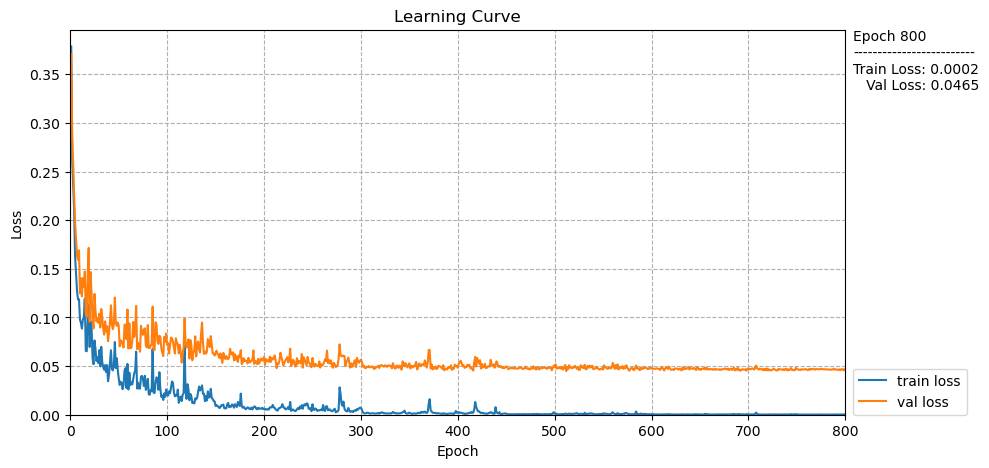

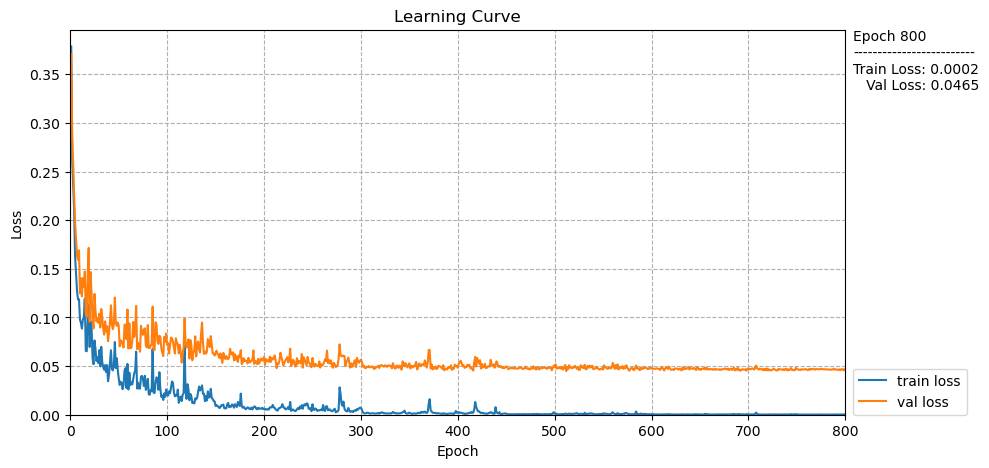

In [835]:
# train the model
if __name__ == '__main__':
    model = Model(**model_config).to(Device)
    losses = train(model, train_data, val_data, **train_config, plot_freq=50)

## Explain your findings (10)
Please explain how you searched for your hyperparameters, and what you learned about the effect of each in the next markdown cell.

RESPONSE:

Hidden Dimensions: I chose [1024, 256, 64, 16], which follows a progressive reduction in dimensions. This structure allows the model to capture complex patterns while reducing parameters in later layers to prevent overfitting.

Number of Epochs: I used 800 epochs since the model benefits from extended training. The loss continued improving over time, justifying the longer training duration.

Batch Size: I set the batch size to 32. A smaller batch size increases noise in gradient updates, which can help escape local minima and improve generalization. Lower batch sizes were noiser. 

Optimizer: I used Adam due to its convergence properties and adaptive learning rate. It also utilizes momentum.

Learning Rate: I set the learning rate to 0.00165, slightly higher than the common 0.001. This helps accelerate convergence while maintaining stability, avoiding the slow updates of a too-low learning rate (like 0.0001) and the instability of a too high one (like 0.01).

Learning Rate Scheduler: I used StepLR with a step size of 150 epochs and a gamma of 0.6. This schedule progressively reduces the learning rate, helping refine the model as training continued and avoiding local minima. This had a big effect on convergence and it was important to pick a value that allowed enough time for each individual learning rate to converge before dropping it

In [859]:
"""
RUN THIS CELL TO SAVE CONFIGS AND MODEL STATE FOR YOUR SUBMISSION
"""
def load_model(
        model_class,
        config: dict, 
        state_dict: dict,
        ):
    model: nn.Module = model_class(**config).cpu()
    model.load_state_dict(state_dict)
    return model

if __name__ == '__main__':
    save_yaml(model_config, 'model_config.yaml')
    save_yaml(train_config, 'train_config.yaml')
    torch.save(model.cpu().state_dict(), 'state_dict.pth')

    # TESTING IF MODEL CAN BE LOADED WITHOUT ERRORS
    model = load_model(
        model_class = Model,
        config = load_yaml('model_config.yaml'),
        state_dict = torch.load('state_dict.pth', map_location='cpu')
    )
    print('Model can be loaded successfully!')

    # You may encounter errors when loading the model config from the yaml file.
    # If so, make sure all arguments are defined as basic python data structures like int, float, str, list, dict, etc.

Model can be loaded successfully!


C:\Users\nickc\AppData\Local\Temp\ipykernel_53760\3889064912.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('state_dict.pth', map_location='cpu

# Zip submission files

You can run the following cell to zip the generated files for submission.

If you are on Colab, make sure to download and then upload a completed copy of the notebook to the working directory so the code can detect and include it in the zip file for submission.

In [862]:
files_to_zip = ['HW2.ipynb', 'model_config.yaml', 'train_config.yaml', 'state_dict.pth']
output_zip = 'HW2_submission.zip'
zip_files(output_zip, *files_to_zip)